# Examples
System regression simultaneously estimates multiple models.  This has three distinct advantages:

* Joint inference across models
* Linear restrictions can be imposed on the parameters across different models
* Improved precision of parameter estimates (depending on the model specification and data)

There are $K$ models and each model can be expressed in vector notation as 

$$ Y_i = X_i\beta_i + \epsilon_i$$

so that the set of models can be expressed as 

$$ Y = X\beta + \epsilon$$

where $Y$ is a column vector that stacks the vectors $Y_i$ for $i=1,2,\ldots,K$, $X$ is a block-diagonal matrix where the i-th block is $X_i$, $\beta$ is a stacked vector of the $K$ $\beta_i$s and $\epsilon$ is similarly comprised of the stacked columns of $\epsilon_i$.

The model can be estimated using OLS with the usual estimator

$$\hat{\beta}_{OLS} = \left(X^\prime X\right)^{-1}X^\prime Y.$$

Since there are multiple series, a GLS estimator that accounts for the cross-sectional heteroskedasticity as well as the correlation of residuals can be estimated 

$$\hat{\beta}_{GLS} = \left(X^\prime \Omega^{-1} X\right)^{-1}X^\prime  \Omega^{-1} Y$$

where $\Omega^{-1} = \Sigma^{-1} \otimes I_{T}$, $\Sigma_{ij}$ is the covariance between $\epsilon_i$ and $\epsilon_j$ and $T$ is the number of observations. The GLS estimator is only beleficial when the regressors in different models differ  and when residuals are correlated. There GLS estimates are identical to the multivariate OLS estimates when all regressors are common.

In [ ]:
# Common libraries
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm

## Data
Two data sets will be used.  The first is from Munnell which looks at the effect of capital on state GDP.  This example follows the example in Chapter 10 in recent editions of Greene's _Econometric Analysis_.

The data is state-level but the model is estimated in region.  The first step is to aggregate the data by region.  All capital measures are summed and the unemployment rate is averaged using weights porportional to the total employment in each state.

In [ ]:
from linearmodels.datasets import munnell
data = munnell.load()

regions = {
    'GF':['AL', 'FL', 'LA', 'MS'],
    'MW':['IL', 'IN', 'KY', 'MI', 'MN', 'OH', 'WI'],
    'MA':['DE', 'MD', 'NJ', 'NY', 'PA', 'VA'],
    'MT' :['CO', 'ID', 'MT', 'ND', 'SD', 'WY'],
    'NE' :['CT', 'ME', 'MA', 'NH', 'RI', 'VT'],
    'SO' :['GA', 'NC', 'SC', 'TN', 'WV', 'AR'],
    'SW' : ['AZ', 'NV', 'NM', 'TX', 'UT'],
    'CN': ['AK', 'IA','KS', 'MO','NE','OK'],
    'WC': ['CA','OR','WA']
}

def map_region(state):
    for key in regions:
        if state in regions[key]:
            return key


data['REGION'] = data.ST_ABB.map(map_region)
data['TOTAL_EMP'] = data.groupby(['REGION','YR'])['EMP'].transform('sum')
data['EMP_SHARE'] = data.EMP / data.TOTAL_EMP
data['WEIGHED_UNEMP'] = data.EMP_SHARE * data.UNEMP

A `groupby` transformation is used to aggregate the data, and finally all values except the unemployment rate are logged.

In [ ]:
grouped = data.groupby(['REGION','YR'])
agg_data = grouped[['GSP','PC','HWY','WATER','UTIL','EMP','WEIGHED_UNEMP']].sum()
for col in ['GSP','PC','HWY','WATER','UTIL','EMP']:
    agg_data['ln'+col] = np.log(agg_data[col])
agg_data['UNEMP'] = agg_data.WEIGHED_UNEMP
agg_data['Intercept'] = 1.0

## Basic Usage

Seemingly Unrelated Models are fairly complex and each equation could have a different number of regressors.  As a result, it isn't possibly to use standard `pandas` or `numpy` data structures, and so dictionaries (or technically dictionary-like objects) are used.  In practice, it is strongly recommended to use a `OrderedDictionary` from the `collections` module.  This ensures that equation order will be preserved. In addition, the dictionary must have the following structure:

* `keys` **must be strings** and will be used as equation labels
* The value associated with each key must be either a dictionary or a tuple.

  * When a dictionary is used, it must have two keys, `dependent` and `exog`.  It can optionaly have a third key `weights` which provides weights to use in the regression.
  * When a tuple is used, it must have two elements and takes the form `(dependent, exog)`.  It can optionally contains weights in which case it takes the form `(dependent, exog, weights)`.

This example uses the dictionary syntax to contain the data for each region and uses the region identified as the equation label.

In [ ]:
from collections import OrderedDict
mod_data = OrderedDict()
for region in ['GF','SW','WC','MT','NE','MA','SO','MW','CN']:
    region_data = agg_data.loc[region]
    dependent = region_data.lnGSP
    exog = region_data[['Intercept', 'lnPC', 'lnHWY', 'lnWATER', 'lnUTIL', 'lnEMP', 'UNEMP']]
    mod_data[region] = {'dependent': dependent, 'exog': exog}

Fitting the model is virtually identical to  fitting any other model with the exception of the special data structure required. 

The fitting options here ensure that the homoskedastic covariance estimator are used (`cov_type='unadjusted'`) and that a small sample adjustment is applied. By default, GLS is used (this can be overridden using `method='ols'`.

In [ ]:
import pandas as pd
from linearmodels.system import SUR
mod = SUR(mod_data)
res = mod.fit(cov_type='unadjusted', debiased=True)

One of the requirements for there to be an efficiency gain in a SUR is that the residuals are correlated. A heatmap is used to inspect this correlation, which is substantial and varies by region.

In [ ]:
cov = res.sigma
std = np.sqrt(np.diag(res.sigma)[:,None])
regions =  [k for k in mod_data.keys()]
corr = pd.DataFrame(cov / (std @ std.T), columns=regions, index=regions)

import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(corr, vmax=.8, square=True)
plt.show()

corr.style.format('{:0.3f}')

These values can be seen to be identical to the reported results in the existing example from Greene.

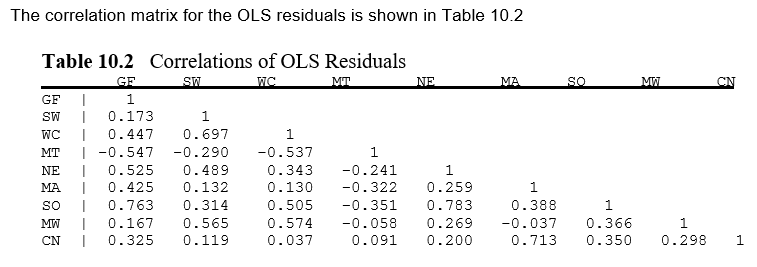

In [35]:
from IPython.display import Image, display_png
display_png(Image('correct-greene-table-10-2.png'))

The full result is fairly long and so here I only pring the first 33 lines which show results for two regions.  By default it reports all estimates along with the usual measures of precision.

In [39]:
print('\n'.join(res.summary.as_text().split('\n')[:33]))

                        System GLS Estimation Summary                         
Estimator:                        GLS   Overall R-squared:              0.9988
No. Equations.:                     9   Cov. Estimator:             unadjusted
No. Observations:                  17   Num. Constraints:                 None
Date:                Wed, Jun 14 2017                                         
Time:                        14:36:22                                         
                                                                              
                                                                              
                   Equation: GF, Dependent Variable: lnGSP                    
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      12.310     2.1216     5.8023     0.0002      7.5829      17.037
lnPC          -0.2010     0.1321    -1.5219     0.15

Individual results are contained in a dictionary located at the attribute `equations` and can be acccessed using equation labels (availablea at the attribute `equation_labels`).  Additional information about the model is presented in this view. The West Coast results are show.  

In [41]:
print(res.equations['WC'])

                            GLS Estimation Summary                            
Eq. Label:                         WC   R-squared:                      0.9920
Dep. Variable:                  lnGSP   Adj. R-squared:                 0.9872
Estimator:                        GLS   Cov. Estimator:             unadjusted
No. Observations:                  17   F-statistic:                    272.49
Date:                Wed, Jun 14 2017   P-value (F-stat)                0.0000
Time:                        14:36:22   Distribution:                  F(6,10)
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      1.9602     3.3365     0.5875     0.5699     -5.4741      9.3944
lnPC           0.1699     0.0813     2.0913     0.06

The current version of the model doesn't faciliate cross equaiton comparrisons and so this is manually implemented here. 

In [44]:
# TODO: Implement method to compare across equations
params = []
for label in res.equation_labels:
    params.append(res.equations[label].params)
params = pd.concat(params,1)
params.columns = res.equation_labels
params.T.style.format('{:0.3f}')

,Intercept,lnPC,lnHWY,lnWATER,lnUTIL,lnEMP,UNEMP
GF,12.310,-0.201,-1.886,0.178,1.190,0.953,-0.003
SW,4.083,0.077,-0.131,-0.136,0.522,0.539,-0.016
WC,1.960,0.170,0.132,-0.347,0.090,1.070,-0.006
MT,3.463,-0.115,0.180,0.262,-0.330,1.079,-0.001
NE,-12.294,0.118,0.934,-0.557,-0.290,2.494,0.020
MA,-18.616,-0.311,3.060,-0.109,-1.659,2.186,0.018
SO,3.162,-0.063,-0.641,-0.081,0.281,1.620,0.008
MW,-9.258,0.096,1.612,0.694,-0.340,-0.062,-0.031
CN,-3.405,0.295,0.934,0.539,0.003,-0.321,-0.029


These results can be compared to the results in Greene -- they are unsurprisingly identical.

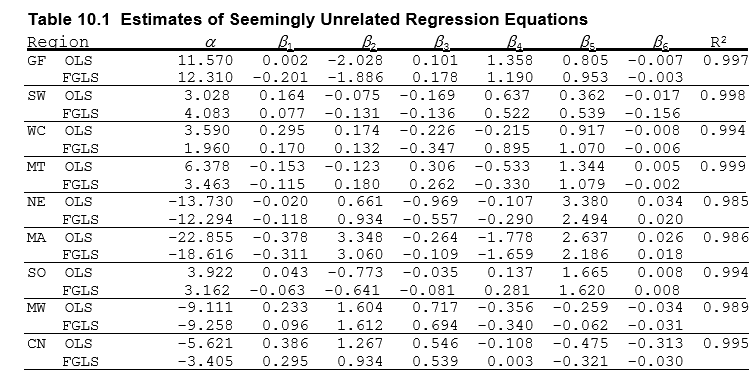

In [45]:
display_png(Image('correct-greene-table-10-1.png'))

The GLS estimation method requires stronger assumptions for parameter estiamtes to be consistent.  If these are violated then it might be the case that OLS is still consistent (in some sense) and so OLS can be used by passing `method='ols'` when calling `fit`. 

These results can be compared simiarly to Greene's table -- they are identical excep tthe final value which seems to have a small typo.

In [48]:
res_ols = mod.fit(method='ols', debiased=True, cov_type='unadjusted')
params = []
r2 = []
for label in res.equation_labels:
    params.append(res_ols.equations[label].params)
    r2.append(res_ols.equations[label].rsquared)
params = pd.concat(params,1)
params.columns = res.equation_labels
params = params.T
params['R2'] = r2
params.style.format('{:0.3f}')

,Intercept,lnPC,lnHWY,lnWATER,lnUTIL,lnEMP,UNEMP,R2
GF,11.567,0.002,-2.029,0.101,1.358,0.805,-0.007,0.997
SW,3.028,0.164,-0.075,-0.169,0.637,0.362,-0.017,0.998
WC,3.590,0.295,0.174,-0.226,-0.214,0.917,-0.008,0.994
MT,6.378,-0.153,-0.123,0.306,-0.533,1.344,0.005,0.999
NE,-13.730,-0.020,0.662,-0.969,-0.107,3.380,0.034,0.985
MA,-22.855,-0.378,3.348,-0.264,-1.778,2.673,0.026,0.986
SO,3.927,0.043,-0.773,-0.035,0.140,1.665,0.008,0.994
MW,-9.111,0.233,1.604,0.717,-0.356,-0.259,-0.034,0.989
CN,-5.621,0.386,1.267,0.546,-0.108,-0.475,-0.031,0.995


The parameter estiamtes for one coefficient -- unemployment -- can be compared across the two estimation methods.  

**Note**: the standard errors for the GLS estimator differ somewhat from Greene.  This is expected since a slightly different formula for the covariance has been used which is consistent.  In particular, the common estimator takes the form 

$$ (X^\prime \Omega^{-1} X)^{-1} $$

where $\Omega$ is estimated from the first-step regression.  The form used in this package is 

$$ (X^\prime \Omega^{-1} X)^{-1} (X^\prime S X) (X^\prime \Omega^{-1} X)^{-1} $$

where $S$ is an estimator of the covariance of the residuals using the GLS parameter estimates. Obviously in the usual form $S=\Omega$.

In [49]:
# TODO: I think this is wrong.  It needs to be checked to ensure that the correct residuals are used!!
params = pd.concat([res_ols.params.iloc[1::7], res_ols.std_errors.iloc[1::7], 
 res.params.iloc[1::7], res.std_errors.iloc[1::7]],1)
params.columns=['OLS', 'OLS se', 'GLS', 'GLS se']
params.index = regions
params

,OLS,OLS se,GLS,GLS se
GF,0.002124,0.301235,-0.200966,0.132051
SW,0.163546,0.165995,0.076637,0.096507
WC,0.294855,0.205417,0.169950,0.081267
MT,-0.152601,0.084031,-0.114834,0.059394
NE,-0.020407,0.285621,0.118316,0.127421
MA,-0.377570,0.167307,-0.310861,0.083619
SO,0.042818,0.279472,-0.063212,0.077437
MW,0.233403,0.206248,0.095886,0.099665
CN,0.385885,0.211083,0.294570,0.079944


In [ ]:
display_png(Image('correct-greene-table-10-3.png'))

In [ ]:
res_het = mod.fit(cov_type='robust', debiased=True)
print(res_het)

## Estimation Options

### Restricted Residual Covariance

### Iterative GLS

In [ ]:
from linearmodels.datasets import fringe
fdata = fringe.load()
fdata.describe()
exog = sm.add_constant(fdata[['educ','exper','expersq','tenure','tenuresq','union','south','nrtheast','nrthcen','married','white','male']])
fmod_data = OrderedDict()
fmod_data['hrearn'] = {'dependent': fdata.hrearn, 'exog': exog}
fmod_data['hrbens'] = {'dependent': fdata.hrbens, 'exog': exog}
fmod = SUR(fmod_data)
print(fmod.fit(cov_type='unadjusted', debiased=True))

In [ ]:
exog_earn = sm.add_constant(fdata[['educ','exper','expersq','union','nrtheast','white']])
exog_bens = sm.add_constant(fdata[['educ','exper','expersq','tenure','tenuresq','union','male']])
fmod_data['hrearn'] = {'dependent': fdata.hrearn, 'exog': exog_earn}
fmod_data['hrbens'] = {'dependent': fdata.hrbens, 'exog': exog_bens}
fmod = SUR(fmod_data)
print(fmod.fit(cov_type='unadjusted', debiased=True))

In [ ]:
fmod_res = fmod.fit(cov_type='unadjusted', debiased=True, iterate=True)
print(fmod_res)

In [ ]:
fmod_res.iterations

### Alternative Covariance Estimators

In [ ]:
mod.fit(cov_type='robust',debiased=True)
mod.fit(cov_type='robust',)

## Pre-specified Residual Covariance Estimators

In [ ]:
avg_corr = (corr - np.eye(9)).mean().mean() * (81/72)
rho = np.ones((9,9)) * avg_corr  + (1-avg_corr) * np.eye(9)
sigma_pre = rho * (std @ std.T)
mod_pre_sigma = SUR(mod_data, sigma=sigma_pre)
res_pre = mod_pre_sigma.fit(cov_type='unadjusted', debiased=True)
print(res_pre.equations['GF'])

## Cross-Equation Restrictions

In [ ]:
mod.param_names[:14]

In [ ]:
r = pd.DataFrame(columns=mod.param_names, index=['rest{0}'.format(i) for i in range(1,9)], dtype=np.float64)
r.loc[:,:] = 0.0
r.iloc[:,6] = -1.0
r.iloc[:,13::7] = np.eye(8)
print(r.iloc[:,6::7])


In [ ]:
r2 = np.zeros((8*6, r.shape[1]))
loc = 0
for i in range(6):
    for j in range(8):
        r2[loc,i+1] = -1
        r2[loc,7*(j+1) + i+1] = 1
        loc += 1
r2=pd.DataFrame(r2, columns=mod.param_names)
mod.reset_constraints()
mod.add_constraints(r2)
mod.fit()

In [ ]:
mod.add_constraints(r)
rest_res = mod.fit(cov_type='unadjusted', debiased=True)
print(rest_res.params.iloc[6::7])

## Multivariate OLS

In [ ]:
import statsmodels.api as sm
from linearmodels.datasets import french
data = french.load()
factors = sm.add_constant(data[['MktRF']])
mv_ols = SUR.multivariate_ls(data[['S1V1','S1V3','S1V5','S5V1','S5V3','S5V5']], factors)
mv_ols_res = mv_ols.fit(cov_type='unadjusted')
print(mv_ols_res)

## Using GLS with common regressors

In [ ]:
print(mv_ols.fit(cov_type='unadjusted', method='gls'))